# Projet FixMatch


## I. Importing libraries and setup

First, we import the libraries we will use in the notebook:

In [ ]:
# !pip install torchview torchsummary torchvision kornia torchmetrics matplotlib tqdm path graphviz opencv-python scikit-learn optuna

In [1]:
# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# vizualisation
import torchsummary

# transforms
import torchvision.transforms as T
import kornia.augmentation as K
from kornia.enhance import normalize
from torchvision.transforms import RandAugment

# metrics
from torchmetrics import Accuracy

# torchvision
import torchvision
import torchvision.transforms as transforms

# plotting
import matplotlib.pyplot as plt
from torchview import draw_graph

from IPython.display import display
from IPython.core.display import SVG, HTML

from tqdm.auto import tqdm

# typing
from typing import Callable

from utils import plot_images, plot_transform

# os
import os
import path

import random
import numpy as np 

# typing
from typing import Callable, List, Tuple

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%load_ext autoreload
%autoreload 2

In [2]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

Then, we setup the device:

In [3]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


We initialize global variables, according to the values in the paper, used in the fixmatch algorithm:

In [4]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.95 #! 0.95 in the paper
LAMBDA_U = 1
MU = 7
BATCH_SIZE = 64
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.001

We create the model:

In [5]:
class ConvNN(nn.Module):
    """
    Simple CNN for CIFAR10
    """
    
    def __init__(self):
        super().__init__()
        self.conv_32 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv_64 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv_96 = nn.Conv2d(64, 96, kernel_size=3, padding='same')
        self.conv_128 = nn.Conv2d(96, 128, kernel_size=3, padding='same')
        self.fc_512 = nn.Linear(512, 512)
        self.fc_10 = nn.Linear(512, 10)
        self.max_pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_32(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_64(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_96(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_128(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.flatten(x)
        x = self.fc_512(x)
        x = self.relu(x)
        x = self.fc_10(x)

        return x

Finally, we download the dataset:

In [6]:
def compute_mean_std(trainLoader) -> Tuple[List[float], List[float]]:
    # initialize the list of means and stds
    mean, std = torch.zeros(3), torch.zeros(3)

    # iterate over the dataset and compute the sum of each channel
    for images, _ in trainLoader:
        mean+= torch.mean(images, dim=[0,2,3])
        std+= torch.std(images, dim=[0,2,3])
    
    # compute the mean and std
    mean = mean/len(trainLoader)
    std = std/len(trainLoader)

    return mean, std

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)

if not os.path.exists('./data/mean.pt'):
    mean, std = compute_mean_std(trainloader)
    torch.save(mean, 'data/mean.pt')
    torch.save(std, 'data/std.pt')
else:
    mean, std = torch.load('./data/mean.pt'), torch.load('./data/std.pt')

# to numpy
mean, std = mean.numpy(), std.numpy()

print(f"mean: {mean}, std: {std}")


testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=3)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
mean: [0.4913966  0.48215377 0.44651437], std: [0.246344   0.24280126 0.26067406]
Files already downloaded and verified


In [7]:
torch_models = 'torch_models' 
if not os.path.exists(torch_models):
    os.makedirs(torch_models)

## II. Convolutional Neural Network - Full Supervised

### II.1. CNN on 100% dataset

In [8]:
seedEverything()

EPOCHS = 29
SUBSET_PROP = 1.00

trainset_subsample, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])
trainloader_subsample = DataLoader(
    trainset_subsample,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# model
model = ConvNN().to(device)

# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)

# Define the learning rate scheduler
lr_lambda = lambda step: LR * 0.5 * (1 + torch.cos(torch.tensor((7 * torch.pi * (step-1)) / (16 * len(trainloader_subsample))))) * 100/3
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
# scheduler = None

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [9]:
# losses
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    correct = 0
    total = 0
    pbar = tqdm(trainloader_subsample, total=len(trainloader_subsample), unit="batch", desc=f"Epoch {epoch: >5}")
    for i, data in enumerate(pbar):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # normalize
        inputs = normalize(data=inputs, mean=mean, std=std)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()

        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        running_accuracy += 100 * correct / total

        current_lr = optimizer.param_groups[0]['lr']

        # Print progress
        pbar.set_postfix({
            "loss": loss.item(),
            "accuracy": 100 * correct / total,
            "lr": current_lr.item()
        })

        if scheduler is not None:
            scheduler.step()

    # update loss
    train_losses.append(running_loss / len(trainloader_subsample))
    train_accuracies.append(running_accuracy / (i+1))
    
    
    

    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(criterion(outputs, labels).item())
        test_accuracies.append(test_accuracy)


Epoch     0:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 61.04%


Epoch     1:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 72.8%


Epoch     2:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 72.68%


Epoch     3:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 62.41%


Epoch     4:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 69.51%


Epoch     5:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 77.18%


Epoch     6:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 80.02%


Epoch     7:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 75.75%


Epoch     8:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 71.07%


Epoch     9:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 75.03%


Epoch    10:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 80.72%


Epoch    11:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 79.83%


Epoch    12:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 72.04%


Epoch    13:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 72.16%


Epoch    14:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 78.6%


Epoch    15:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 81.11%


Epoch    16:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 79.21%


Epoch    17:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 65.44%


Epoch    18:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 74.77%


Epoch    19:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 80.15%


Epoch    20:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 80.99%


Epoch    21:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 77.32%


Epoch    22:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 70.31%


Epoch    23:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 78.1%


Epoch    24:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 81.1%


Epoch    25:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 80.32%


Epoch    26:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 73.92%


Epoch    27:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 73.94%


Epoch    28:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 80.49%


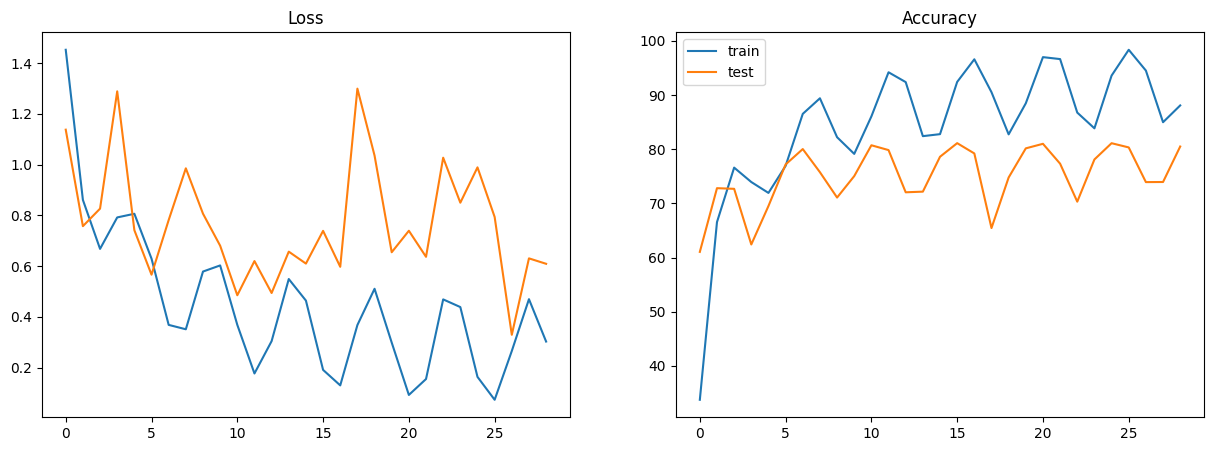

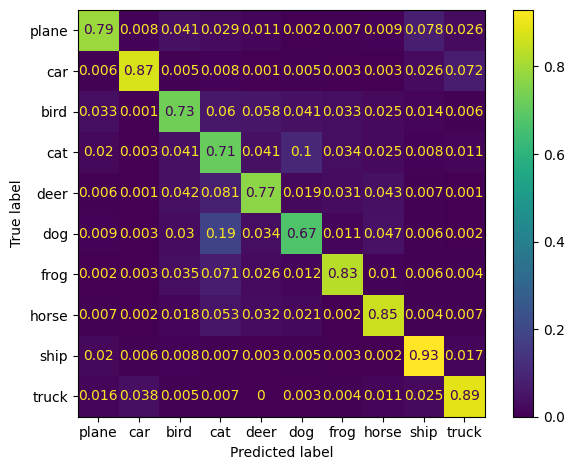

In [11]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies, label="train")
ax2.plot(test_accuracies, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"figures/sup_1_losses_accuracies.png")

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()

# save plot
fig.savefig(f"figures/sup_1_confusion_matrix.png")

Test Accuracy: 80.49%


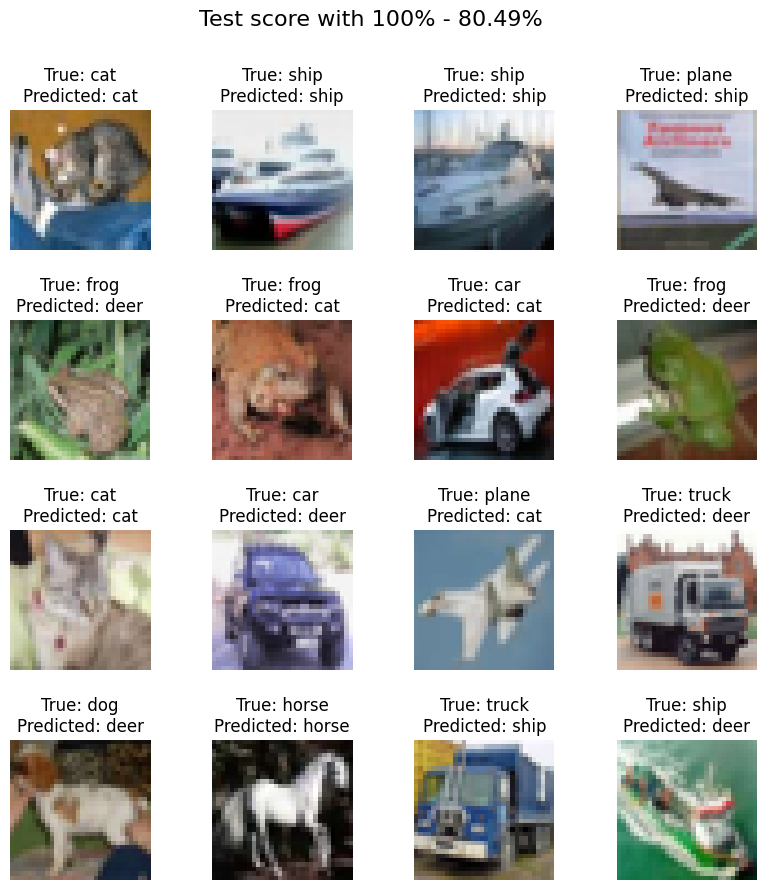

In [12]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_100.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}.png")

### II.2 CNN on 10% dataset

In [ ]:
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.10

trainset_subsample, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])
trainloader_subsample = DataLoader(
    trainset_subsample,
    batch_size=int(BATCH_SIZE * SUBSET_PROP),
    shuffle=True,
    num_workers=0
)

# model
model = ConvNN().to(device)

# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# Define the learning rate scheduler
lr_lambda = lambda step: LR * 0.5 * (1 + torch.cos(torch.tensor((7 * torch.pi * (step-1)) / (16 * EPOCHS))))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
# scheduler = None

In [ ]:
# losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(trainloader_subsample, total=len(trainloader_subsample), unit="batch", desc=f"Epoch {epoch: >5}")
    for i, data in enumerate(pbar):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # normalize
        inputs = normalize(data=inputs, mean=mean, std=std)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        current_lr = optimizer.param_groups[0]['lr']

        # Print progress
        pbar.set_postfix(loss=running_loss / (i + 1), accuracy=100.0 * correct / total, lr=current_lr.item())

        

    # update loss
    train_losses.append(running_loss / len(trainloader_subsample))
    
    if scheduler is not None:
        scheduler.step()
   

    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(criterion(outputs, labels).item())


In [ ]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0


with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_10.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image # * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}.png")

### II.3 CNN on 5% dataset

In [ ]:
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.05

trainset_subsample, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])
trainloader_subsample = DataLoader(
    trainset_subsample,
    batch_size=int(BATCH_SIZE * SUBSET_PROP),
    shuffle=True,
    num_workers=0
)

# model
model = ConvNN().to(device)

# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# Define the learning rate scheduler
lr_lambda = lambda step: LR * 0.5 * (1 + torch.cos(torch.tensor((7 * torch.pi * (step-1)) / (16 * len(trainloader_subsample)))))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
# scheduler = None

In [ ]:
# losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(trainloader_subsample, total=len(trainloader_subsample), unit="batch", desc=f"Epoch {epoch: >5}")
    for i, data in enumerate(pbar):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # normalize
        inputs = normalize(data=inputs, mean=mean, std=std)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        current_lr = optimizer.param_groups[0]['lr']

        # Print progress
        pbar.set_postfix(loss=running_loss / (i + 1), accuracy=100.0 * correct / total, lr=current_lr.item())

    # update loss
    train_losses.append(running_loss / len(trainloader_subsample))
    
    if scheduler is not None:
        scheduler.step()

    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(criterion(outputs, labels).item())


In [ ]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_5.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image # * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}.png")

### II.4 CNN on 1% dataset

In [ ]:
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.01

trainset_subsample, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])
trainloader_subsample = DataLoader(
    trainset_subsample,
    batch_size=int(BATCH_SIZE * SUBSET_PROP) + 1,
    shuffle=True,
    num_workers=0
)

# model
model = ConvNN().to(device)

# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# Define the learning rate scheduler
lr_lambda = lambda step: LR * 0.5 * (1 + torch.cos(torch.tensor((7 * torch.pi * (step-1)) / (16 * len(trainloader_subsample)))))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
# scheduler = None

In [ ]:
# losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(trainloader_subsample, total=len(trainloader_subsample), unit="batch", desc=f"Epoch {epoch: >5}")
    for i, data in enumerate(pbar):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # normalize
        inputs = normalize(data=inputs, mean=mean, std=std)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        current_lr = optimizer.param_groups[0]['lr']

        # Print progress
        pbar.set_postfix(loss=running_loss / (i + 1), accuracy=100.0 * correct / total, lr=current_lr.item())

        

    # update loss
    train_losses.append(running_loss / len(trainloader_subsample))
    
    if scheduler is not None:
        scheduler.step()

    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(criterion(outputs, labels).item())


In [ ]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_1.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image # * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}.png")

## III. Convolution Neural Network - Full Supervised - Active Learning approach

Let's assume we know only the labels of the images of 5% of the dataset and computing more labels is expensive (time, resourcers). Therefore, we choose an active learning approach where we will "compute", according to a querying strategy, new labels from the dataset.

In [ ]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 100
SUBSET_PROP = 0.01
TARGET_SUBSET_PROP = 0.05

trainset_lab, trainset_unlab = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

labeled_dataloader = DataLoader(
    trainset_lab,
    batch_size=int(BATCH_SIZE * SUBSET_PROP) + 1,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unlab,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# indices of labeled data
labeled_indices = trainset_lab.indices

# indices of unlabeled data
unlabeled_indices = trainset_unlab.indices


mean, std = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])

model = ConvNN().to(device)

# criterion and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# Define the cosine learning rate decay function
lr_lambda = lambda step: LR * 0.5 * (1 + torch.cos(torch.tensor((7 * torch.pi * step) / (16 * EPOCHS))))

# Create a learning rate scheduler with the cosine decay function
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
scheduler = None


In [ ]:
# Compute uncertainty scores using entropy
from scipy.stats import entropy

# Active Learning approach for selecting data
def select_samples_active_learning(model, unlabeled_dataloader, num_samples):
    scores = []
    for images, _ in unlabeled_dataloader:
        images = images.to(device)
        logits = model(images)
        entr = entropy(logits.detach().cpu().numpy())
        scores.append(entr)
        
    scores = np.concatenate(scores)

    # sort scores from highest to lowest
    
    scores_sorted = np.sort(scores)[::-1]

    # Select top-k samples based on uncertainty scores
    selected_indices = np.argsort(scores_sorted)[:num_samples]
    selected_scores = scores_sorted[:num_samples]

    return selected_indices, selected_scores

# Create a new labeled dataset using active learning
def create_labeled_dataset_active_learning(dataset, selected_indices):
    labeled_dataset = torch.utils.data.Subset(dataset, selected_indices)
    return labeled_dataset

In [ ]:
print("Start training")

max_iter = 500

# training loop
subset_length = len(trainset_lab)
current_proportion = subset_length / len(trainset)

scores = np.array([np.inf])
i = 0

# training loop
while current_proportion <= TARGET_SUBSET_PROP and i < max_iter:
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(labeled_dataloader, total=len(labeled_dataloader), unit="batch", desc=f"Epoch {i: >5}")
    for j, data in enumerate(pbar):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # normalize
        inputs = normalize(data=inputs, mean=mean, std=std)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        current_lr = optimizer.param_groups[0]['lr']

        # Print progress
        pbar.set_postfix(loss=running_loss / (j + 1), accuracy=100.0 * correct / total, lr=current_lr, prop=current_proportion, scores=scores.mean(), length_lab=len(labeled_indices), length_unlab=len(unlabeled_indices))

    # compute data where uncertainty is higher
    selected_indices, scores = select_samples_active_learning(model, unlabeled_dataloader, num_samples=20)
    
    # add selected indices to labeled indices
    labeled_indices = np.concatenate((labeled_indices, selected_indices))

    # remove selected indices from unlabeled indices
    unlabeled_indices = np.setdiff1d(unlabeled_indices, selected_indices)

    # create new dataset from labeled indices
    trainset_subsample = create_labeled_dataset_active_learning(trainset, selected_indices)

    # update dataloader
    labeled_dataloader = DataLoader(
        trainset_subsample,
        batch_size=1,
        shuffle=True,
        num_workers=0
    )

    # update unlabeled dataset
    trainset_unlab = torch.utils.data.Subset(trainset, unlabeled_indices)

    # update unlabeled dataloader
    unlabeled_dataloader = DataLoader(
        trainset_unlab,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0
    )

    # update current proportion
    subset_length = len(labeled_indices)
    current_proportion = subset_length / len(trainset)

    if scheduler is not None:
        scheduler.step()

    i += 1

In [ ]:
# check for duplicates in labeled indices
unique, counts = np.unique(labeled_indices, return_counts=True)

print(f"Number of duplicates: {np.sum(counts > 1)}")
print(f"Number of labeled indices: {len(labeled_indices)}")

In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_5_AL.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image # * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with AL - {int(current_proportion*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{current_proportion}_AL.png")

## III. Semi-Supervised Learning: Fixmatch

### III.1 Fixmatch on 10% train data

In [ ]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 150
SUBSET_PROP = 0.10

trainset_sup, trainset_unsup = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

In [ ]:
# transformations
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), 
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)),
)

strong_transform = K.ImageSequential(
    K.auto.RandAugment(n=2, m=10), # randaugment + cutout
)

In [ ]:
def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()
        logits = model(weak_unlabeled_data)
        probs = torch.softmax(logits, dim=1)
        scores, labels = torch.max(probs, dim=1)
        idx = scores > TAU
        labels = labels[idx]

    return labels.detach(), idx, scores

In [ ]:
model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss()
unlabeled_criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# Define the cosine learning rate decay function
lr_lambda = lambda step: LR * 0.5 * (1 + torch.cos(torch.tensor((7 * torch.pi * (step-1)) / (16 * len(trainloader_subsample))))) * 100/3

# Create a learning rate scheduler with the cosine decay function
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = None

In [ ]:
print("Start training")

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    max_confidence = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labeled_labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, unlabeled_labels = unlabeled_data[0].to(device), unlabeled_data[1].to(device)

        # normalize
        # labeled_inputs = normalize(data=labeled_inputs, mean=mean, std=std)
        # unlabeled_inputs = normalize(data=unlabeled_inputs, mean=mean, std=std)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)

        # normalize
        weak_labeled_inputs = normalize(data=weak_labeled_inputs, mean=mean, std=std)
        strong_unlabeled_inputs = normalize(data=strong_unlabeled_inputs, mean=mean, std=std)
        weak_unlabeled_inputs = normalize(data=weak_unlabeled_inputs, mean=mean, std=std)

        # Compute mask, confidence
        pseudo_labels, idx, scores = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels = torch.cat((labeled_labels, pseudo_labels))

            # forward pass
            outputs = model(inputs)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = labeled_criterion(labeled_outputs, labeled_labels)
            unlabeled_loss = unlabeled_criterion(unlabeled_outputs, pseudo_labels)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += (labeled_labels.size(0) + n_unlabeled)
            correct += (outputs.argmax(dim=1) == torch.cat((labeled_labels, pseudo_labels))).sum().item()
            
        else:
            # forward pass
            outputs = model(weak_labeled_inputs)

            # compute loss
            labeled_loss = labeled_criterion(outputs, labeled_labels)
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labeled_labels.size(0)
            correct += (outputs.argmax(dim=1) == labeled_labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        max_confidence = max(max_confidence, scores.max().item())

        

        # update progress bar
        pbar.set_postfix({
            "total loss": running_loss / (i + 1),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": max_confidence,
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr'].item()
        })

    # update loss
    train_losses.append(running_loss / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(labeled_criterion(outputs, labels).item())


In [ ]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_10_fixmatch.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}_fixmatch.png")

### III.2 Fixmatch on 5% train data

In [ ]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 150
SUBSET_PROP = 0.05

trainset_sup, trainset_unsup = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), 
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)),
)

strong_transform = K.ImageSequential(
    K.auto.RandAugment(n=2, m=10), # randaugment + cutout
)

def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()
        logits = model(weak_unlabeled_data)
        probs = torch.softmax(logits, dim=1)
        scores, labels = torch.max(probs, dim=1)
        idx = scores > TAU
        labels = labels[idx]

    return labels.detach(), idx, scores

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss()
unlabeled_criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# Define the cosine learning rate decay function
lr_lambda = lambda step: LR * 0.5 * (1 + torch.cos(torch.tensor((7 * torch.pi * step) / (16 * EPOCHS))))

# Create a learning rate scheduler with the cosine decay function
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = None

In [ ]:
print("Start training")

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    max_confidence = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labeled_labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, unlabeled_labels = unlabeled_data[0].to(device), unlabeled_data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)

        # normalize
        weak_labeled_inputs = normalize(data=weak_labeled_inputs, mean=mean, std=std)
        strong_unlabeled_inputs = normalize(data=strong_unlabeled_inputs, mean=mean, std=std)
        weak_unlabeled_inputs = normalize(data=weak_unlabeled_inputs, mean=mean, std=std)

        # Compute mask, confidence
        pseudo_labels, idx, scores = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels = torch.cat((labeled_labels, pseudo_labels))

            # forward pass
            outputs = model(inputs)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = labeled_criterion(labeled_outputs, labeled_labels)
            unlabeled_loss = unlabeled_criterion(unlabeled_outputs, pseudo_labels)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += (labeled_labels.size(0) + n_unlabeled)
            correct += (outputs.argmax(dim=1) == torch.cat((labeled_labels, pseudo_labels))).sum().item()
            
        else:
            # forward pass
            outputs = model(weak_labeled_inputs)

            # compute loss
            labeled_loss = labeled_criterion(outputs, labeled_labels)
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labeled_labels.size(0)
            correct += (outputs.argmax(dim=1) == labeled_labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        max_confidence = max(max_confidence, scores.max().item())

        

        # update progress bar
        pbar.set_postfix({
            "total loss": running_loss / (i + 1),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": max_confidence,
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr'].item()
        })

    # update loss
    train_losses.append(running_loss / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(labeled_criterion(outputs, labels).item())

In [ ]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_5_fixmatch.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}_fixmatch.png")

### III.3 Fixmatch on 1% train data

In [ ]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 150
SUBSET_PROP = 0.01

trainset_sup, trainset_unsup = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE*1/MU,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), 
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)),
)

strong_transform = K.ImageSequential(
    K.auto.RandAugment(n=2, m=10), # randaugment + cutout
)

def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()
        logits = model(weak_unlabeled_data)
        probs = torch.softmax(logits, dim=1)
        scores, labels = torch.max(probs, dim=1)
        idx = scores > TAU
        labels = labels[idx]

    return labels.detach(), idx, scores

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss()
unlabeled_criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# Define the cosine learning rate decay function
lr_lambda = lambda step: LR * 0.5 * (1 + torch.cos(torch.tensor((7 * torch.pi * step) / (16 * EPOCHS))))

# Create a learning rate scheduler with the cosine decay function
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = None

In [ ]:
print("Start training")

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    max_confidence = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labeled_labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, unlabeled_labels = unlabeled_data[0].to(device), unlabeled_data[1].to(device)

        # normalize
        # labeled_inputs = normalize(data=labeled_inputs, mean=mean, std=std)
        # unlabeled_inputs = normalize(data=unlabeled_inputs, mean=mean, std=std)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)

        # normalize
        weak_labeled_inputs = normalize(data=weak_labeled_inputs, mean=mean, std=std)
        strong_unlabeled_inputs = normalize(data=strong_unlabeled_inputs, mean=mean, std=std)
        weak_unlabeled_inputs = normalize(data=weak_unlabeled_inputs, mean=mean, std=std)

        # Compute mask, confidence
        pseudo_labels, idx, scores = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels = torch.cat((labeled_labels, pseudo_labels))

            # forward pass
            outputs = model(inputs)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = labeled_criterion(labeled_outputs, labeled_labels)
            unlabeled_loss = unlabeled_criterion(unlabeled_outputs, pseudo_labels)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += (labeled_labels.size(0) + n_unlabeled)
            correct += (outputs.argmax(dim=1) == torch.cat((labeled_labels, pseudo_labels))).sum().item()
            
        else:
            # forward pass
            outputs = model(weak_labeled_inputs)

            # compute loss
            labeled_loss = labeled_criterion(outputs, labeled_labels)
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labeled_labels.size(0)
            correct += (outputs.argmax(dim=1) == labeled_labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        max_confidence = max(max_confidence, scores.max().item())

        

        # update progress bar
        pbar.set_postfix({
            "total loss": running_loss / (i + 1),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": max_confidence,
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr'].item()
        })

    # update loss
    train_losses.append(running_loss / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(labeled_criterion(outputs, labels).item())


In [ ]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_1_fixmatch.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}_fixmatch.png")

### III.2 Fixmatch with smart 10% choice

#### a. Active Learning approach

Let's assume that only 1% of the labels from the dataset is known and it is consuming (time, resources) to compute the other labels.

Therefore, the active learning approach consists to, according to a querying strategy, compute the labels from the images that provide the most information.

In [ ]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 100
SUBSET_PROP = 0.01

trainset_sup, trainset_unsup = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)


# transformations
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), 
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)),
)

strong_transform = K.ImageSequential(
    K.auto.RandAugment(n=2, m=10), # randaugment + cutout
)

def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()
        logits = model(weak_unlabeled_data)
        probs = torch.softmax(logits, dim=1)
        scores, labels = torch.max(probs, dim=1)
        idx = scores > TAU
        labels = labels[idx]

    return labels.detach(), idx, scores

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss()
unlabeled_criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# Define the cosine learning rate decay function
lr_lambda = lambda step: LR * 0.5 * (1 + torch.cos(torch.tensor((7 * torch.pi * step) / (16 * EPOCHS))))

# Create a learning rate scheduler with the cosine decay function
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = None

In [ ]:
mean, std = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])

# transformations
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), 
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)),
)

strong_transform = K.ImageSequential(
    K.auto.RandAugment(n=2, m=10), # randaugment + cutout
)

def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()
        logits = model(weak_unlabeled_data)
        probs = torch.softmax(logits, dim=1)
        scores, labels = torch.max(probs, dim=1)
        idx = scores > TAU
        labels = labels[idx]

    return labels.detach(), idx, scores

In [ ]:
model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss()
unlabeled_criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
# scheduler = None

In [ ]:
print("Start training")


for epoch in range(EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    max_confidence = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labeled_labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, unlabeled_labels = unlabeled_data[0].to(device), unlabeled_data[1].to(device)

        # normalize
        # labeled_inputs = normalize(data=labeled_inputs, mean=mean, std=std)
        # unlabeled_inputs = normalize(data=unlabeled_inputs, mean=mean, std=std)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)

        # normalize
        weak_labeled_inputs = normalize(data=weak_labeled_inputs, mean=mean, std=std)
        strong_unlabeled_inputs = normalize(data=strong_unlabeled_inputs, mean=mean, std=std)
        weak_unlabeled_inputs = normalize(data=weak_unlabeled_inputs, mean=mean, std=std)

        # Compute mask, confidence
        pseudo_labels, idx, scores = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels = torch.cat((labeled_labels, pseudo_labels))

            # forward pass
            outputs = model(inputs)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = labeled_criterion(labeled_outputs, labeled_labels)
            unlabeled_loss = unlabeled_criterion(unlabeled_outputs, pseudo_labels)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss
            
        else:
            # forward pass
            outputs = model(weak_labeled_inputs)

            # compute loss
            labeled_loss = labeled_criterion(outputs, labeled_labels)
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        # scheduler step
        if scheduler is not None:
            scheduler.step()

        # update statistics
        running_loss += loss.item()
        total += labeled_labels.size(0)
        correct += (outputs.argmax(dim=1) == torch.cat((labeled_labels, pseudo_labels))).sum().item()
        running_n_unlabeled += n_unlabeled
        max_confidence = max(max_confidence, scores.max().item())

        

        # update progress bar
        pbar.set_postfix({
            "total loss": running_loss / (i + 1),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": max_confidence,
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr']
        })